# Fortran Example 1: A simple example for OBS

In this example we generate Green's functions and P receiver functions for an ocean-bottom seismic stations. This example follows that of Figure 2 in Audet (GJI, 2016). 

Start by importing the necessary modules

In [1]:
import numpy as np
from obspy.core import Stream, Trace
from obspy.signal.rotate import rotate_ne_rt
from telewavesim import green as gp
from telewavesim import utils as ut
from telewavesim import wiggle as wg
from telewavesim import conf as cf

/Users/pascalaudet/anaconda3/envs/tws-dev/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


In addition to the previous imports, we need to import the compiled Fortran modules to pass global variables and run the main routine

In [2]:
from telewavesim.rmat_f import green as gp_f
from telewavesim.rmat_f import conf as cf_f

Select the model file:

In [3]:
modfile = '../../models/model_Audet2016.txt'

Select the type of incident wave - options are `'P'`, `'SV'`, `'SH'`, or `'Si'`, which is an isotropic S-wave source

In [4]:
cf.wvtype = 'P'

Next we use global variables to define the desired time series

In [5]:
cf.nt = 3000 # Number of samples
cf.dt = 0.01 # sampling rate in seconds

Here we choose to model the Green's functions for an ocean-bottom station, so we specify the deployment depth

In [6]:
cf.dp = 2000. # Deployment depth below sea level in meters

The parameters (P-wave velocity and density) of the water layer have default values of 1500 m/s and 1027 kg/m^3, respectively, but these values can be changed here

In [7]:
cf.c = 1500.    # P-wave velocity in salt water (m/s)
cf.rhof = 1027. # Density of salt water (kg/m^3)

Here we need a call to pass the global Python variables to their Fortran equivalent

In [8]:
ut.obs2for()

Now specify the parameters of the incident wavefield in terms of a horizontal slowness and back-azimuth.

In [9]:
cf.slow = 0.06 # Horizontal slowness (or ray parameter) in s/km 
cf.baz = 0.    # Back-azimuth direction in degrees (has no influence if model is isotropic)

Once again, pass global parameters to Fortran

In [10]:
ut.wave2for()

Read the model parameters from the model file and set global variables (hidden in the function). Up to here, the steps could have been performed in no particular order, except the name of the file that needs to be defined before the call to `read_model()`

In [11]:
ut.read_model(modfile)

Another call to pass the model parameters to global variables in Fortran

In [12]:
ut.model2for()

The following step is useful for plotting the Green's functions with respect to the predicted propagation time through the model (from lowermost interface up to the seafloor). 

In [13]:
t1 = ut.calc_ttime(cf.slow)
print('Predicted propagation time from model: {0:4.1f} sec'.format(t1))

Predicted propagation time from model:  1.1 sec


This is the main part of the code, where we generate the Green's functions by calling the `green` module. The Fortran implementation returns the time series (as opposed to an `obspy` `Stream` object), so we need a few extra calls to store the output to a 3-component `Stream` with individual traces oriented in North, East and Vertical directions.

In [14]:
# Calculate the Green's functions
ux, uy, uz = gp_f.green_obs(cf.nt,cf.nlay,np.array(cf.wvtype, dtype='c'))

# Store in traces
tux = Trace(data=ux)
tuy = Trace(data=uy)
tuz = Trace(data=uz)

# Update trace header
tux = ut.update_stats(tux, cf.nt, cf.dt, cf.slow, cf.baz)
tuy = ut.update_stats(tuy, cf.nt, cf.dt, cf.slow, cf.baz)
tuz = ut.update_stats(tuz, cf.nt, cf.dt, cf.slow, cf.baz)

# Append to stream
trxyz_f = Stream(traces=[tux, tuy, tuz])

We could also calculate the transfer functions between components - here since the incident wave is a P-wave, we can get the radial and transverse transfer functions as an `obspy` `Stream` object. The option `pvh=False` tells the code to use the regular Z-R-T geometry. The option `pvh=True` (default) rotates the components to the P-SV-SH wave modes using the seismic velocity of the topmost solid layer. 

In [16]:
tfs = gp.tf_from_xyz(trxyz_f, pvh=False)

Here we can extract individual components as `obspy` `Traces` and rotate them to the Radial and Transverse directions

In [17]:
ntr = trxyz_f[0] # North component
etr = trxyz_f[1] # East component
ztr = trxyz_f[2] # Vertical component

# Copy to radial and transverse
rtr = ntr.copy() # Radial component
ttr = etr.copy() # Transverse component

# Rotate to radial and transverse
rtr.data, ttr.data = rotate_ne_rt(ntr.data, etr.data, cf.baz)

For plotting purposes, we create a new `obspy` `Stream` object that includes one transfer function and two Green's functions

In [18]:
strf = Stream(traces=[tfs[0],ztr,rtr])

Now plot the result as wiggles, using the format displayed in the paper by Audet (GJI, 2016). First you will have to define frequency corners.

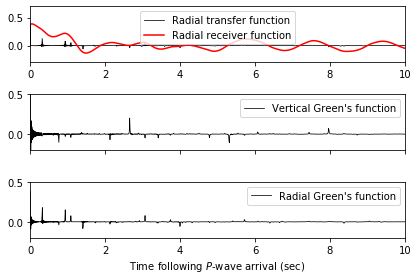

In [19]:
# Set frequency corners in Hz
f1 = 0.1
f2 = 1.0

# Plot as wiggles
wg.gf_wiggles_Audet2016(strf, t1=t1, tmax=10., f1=f1, f2=f2, scale=2.e-7, save=False, title='')

That's it! You can play with these parameters and change the model file (while respecting its format) and see how the seismograms change.